In [1]:
# Imports
import pandas as pd

pd.set_option("display.max_columns", 20)
pd.set_option("display.max_rows", 10)

In [2]:
# Define file paths
CELL_TYPES_FILE = "data/consolidated_cell_types.csv.gz"
CONNECTIONS_FILE = "data/connections_princeton_no_threshold.csv.gz"

In [3]:
# Load cell types
cell_types = pd.read_csv(CELL_TYPES_FILE)

print("Cell types shape:", cell_types.shape)
cell_types.head()

Cell types shape: (137677, 3)


,root_id,primary_type,additional_type(s)
0,720575940596125868,T5c,NaN
1,720575940597856265,Tm16,NaN
2,720575940597944841,Tm7,CB3851
3,720575940598267657,TmY15,NaN
4,720575940599333574,Tm1,NaN


In [4]:
# Load connections (note: large file!)
# Using low_memory=False to avoid dtype warnings
connections = pd.read_csv(CONNECTIONS_FILE, low_memory=False)

print("Connections shape:", connections.shape)
connections.head()

Connections shape: (22285323, 5)


,pre_root_id,post_root_id,neuropil,syn_count,nt_type
0,720575940625363947,720575940623224444,ME_L,12,GABA
1,720575940613354467,720575940616690107,ME_L,1,ACH
2,720575940630432382,720575940618518557,ME_L,67,ACH
3,720575940627314521,720575940626337738,ME_L,10,GABA
4,720575940616775218,720575940632128018,ME_L,1,ACH


In [5]:
# Quick sanity checks
print("Unique root IDs in cell types:", cell_types['root_id'].nunique())
print("Unique pre IDs in connections:", connections['pre_root_id'].nunique())
print("Unique post IDs in connections:", connections['post_root_id'].nunique())

# Are all root_ids in connections also present in cell_types?
missing_pre = set(connections['pre_root_id']) - set(cell_types['root_id'])
missing_post = set(connections['post_root_id']) - set(cell_types['root_id'])

print("Missing pre IDs:", len(missing_pre))
print("Missing post IDs:", len(missing_post))

Unique root IDs in cell types: 137677
Unique pre IDs in connections: 139003
Unique post IDs in connections: 138955
Missing pre IDs: 1572
Missing post IDs: 1570


In [6]:
# Merge connections with cell types (for pre and post separately)
connections_with_types = (
    connections
    .merge(cell_types[['root_id', 'primary_type']], 
           left_on='pre_root_id', right_on='root_id', how='left')
    .rename(columns={'primary_type': 'pre_type'})
    .drop(columns=['root_id'])
    .merge(cell_types[['root_id', 'primary_type']], 
           left_on='post_root_id', right_on='root_id', how='left')
    .rename(columns={'primary_type': 'post_type'})
    .drop(columns=['root_id'])
)

print(connections_with_types.shape)
connections_with_types.head()


(22285323, 7)


,pre_root_id,post_root_id,neuropil,syn_count,nt_type,pre_type,post_type
0,720575940625363947,720575940623224444,ME_L,12,GABA,Dm6,T1
1,720575940613354467,720575940616690107,ME_L,1,ACH,L3,Lawf2
2,720575940630432382,720575940618518557,ME_L,67,ACH,L2,L5
3,720575940627314521,720575940626337738,ME_L,10,GABA,Tm5c,Tm21
4,720575940616775218,720575940632128018,ME_L,1,ACH,T2a,Dm3q


In [7]:
# Check how many connections have missing type annotations
missing_pre_types = connections_with_types['pre_type'].isna().sum()
missing_post_types = connections_with_types['post_type'].isna().sum()

print("Connections missing pre_type:", missing_pre_types)
print("Connections missing post_type:", missing_post_types)

Connections missing pre_type: 214817
Connections missing post_type: 190836


In [8]:
# Drop connections where either side is missing type
connections_clean = connections_with_types.dropna(subset=['pre_type', 'post_type'])

print("Connections before cleaning:", len(connections_with_types))
print("Connections after cleaning:", len(connections_clean))

Connections before cleaning: 22285323
Connections after cleaning: 21890045


In [9]:
# Construct long-format neuron → partner_type mapping

# Pre neuron side: map pre_root_id to post_type
pre_df = connections_clean[['pre_root_id', 'post_type']].rename(
    columns={'pre_root_id': 'neuron_id', 'post_type': 'partner_type'}
)

# Post neuron side: map post_root_id to pre_type
post_df = connections_clean[['post_root_id', 'pre_type']].rename(
    columns={'post_root_id': 'neuron_id', 'pre_type': 'partner_type'}
)

# Combine them
long_df = pd.concat([pre_df, post_df], ignore_index=True)

print("Long-format rows:", len(long_df))
long_df.head()

Long-format rows: 43780090


,neuron_id,partner_type
0,720575940625363947,T1
1,720575940613354467,Lawf2
2,720575940630432382,L5
3,720575940627314521,Tm21
4,720575940616775218,Dm3q


In [10]:
# Count unique partner types per neuron
partner_type_counts = (
    long_df
    .dropna(subset=['partner_type'])                # just in case
    .groupby('neuron_id')['partner_type']
    .nunique()
    .reset_index(name='unique_partner_type_count')
)

print("Result shape:", partner_type_counts.shape)
partner_type_counts.head()

Result shape: (137540, 2)


,neuron_id,unique_partner_type_count
0,720575940596125868,46
1,720575940597856265,165
2,720575940597944841,136
3,720575940598267657,148
4,720575940599333574,76


In [11]:
# Add each neuron's own type for context
results = partner_type_counts.merge(
    cell_types[['root_id', 'primary_type']], 
    left_on='neuron_id', right_on='root_id', how='left'
).drop(columns=['root_id'])

results = results.rename(columns={'primary_type': 'neuron_type'})

results.head()

,neuron_id,unique_partner_type_count,neuron_type
0,720575940596125868,46,T5c
1,720575940597856265,165,Tm16
2,720575940597944841,136,Tm7
3,720575940598267657,148,TmY15
4,720575940599333574,76,Tm1


In [12]:
# Define neurons of interest
neurons_of_interest = {
    "OviEN": {
        720575940612490958: "oviEN Left",
        720575940635515744: "oviEN Right",
    },
    "oviIN": {
        720575940628360506: "oviIN Left",
        720575940625741287: "oviIN Right",
    },
    "PAL02": {
        720575940628717585: "PAL02 Left",
        720575940620716897: "PAL02 Right",
    },
    "PAL04": {
        720575940632369439: "PAL04 Left",
        720575940636990064: "PAL04 Right",
    },
    "Earmuff": {
        720575940629861163: "Earmuff Left 1",
        720575940611411057: "Earmuff Right 1",
        720575940635642725: "Earmuff Left 2",
        720575940629013199: "Earmuff Right 2",
    },
    "Tophat": {
        720575940660281217: "Tophat Left 1",
        720575940620441024: "Tophat Right 1",
        720575940622541005: "Tophat Left 2",
        720575940638865011: "Tophat Right 2",
    },
    "SMP": {
        720575940633705636: "SMP544"
    }
}

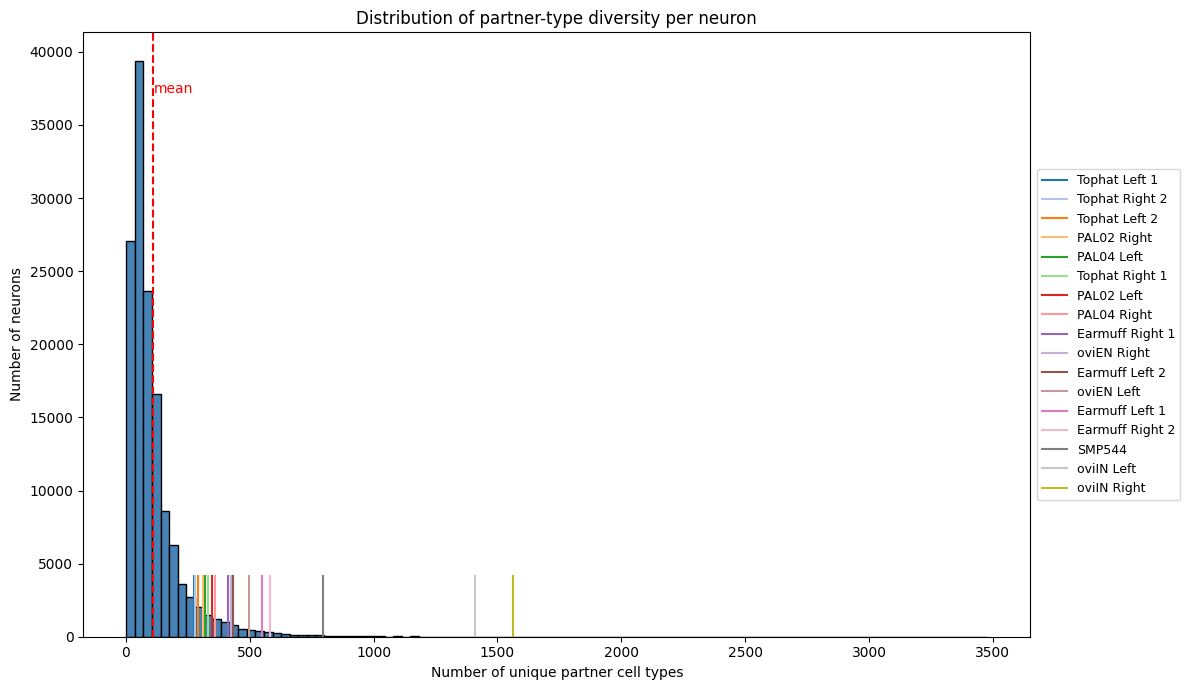

In [13]:
# Generate figure
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# Compute mean
mean_val = results['unique_partner_type_count'].mean()

# Plot histogram
plt.figure(figsize=(12,7))
plt.hist(results['unique_partner_type_count'], bins=100, color='steelblue', edgecolor='black')

# Add mean line
plt.axvline(mean_val, color='red', linestyle='--')
plt.text(mean_val+5, plt.ylim()[1]*0.9, 'mean', color='red')

# Flatten neurons_of_interest into a list of (val, label)
points = []
for group, mapping in neurons_of_interest.items():
    for nid, label in mapping.items():
        match = results.query("neuron_id == @nid")
        if not match.empty:
            val = match['unique_partner_type_count'].iloc[0]
            points.append((val, label))

# Sort by x-axis position (val)
points.sort(key=lambda x: x[0])

# Pick a colormap for distinct colors
cmap = mpl.colormaps['tab20']

# Plot each neuron as a colored vertical line
for i, (val, label) in enumerate(points):
    color = cmap(i)
    plt.axvline(val, color=color, linestyle='-', ymax=0.1, label=label)

# Add legend outside plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)

plt.xlabel("Number of unique partner cell types")
plt.ylabel("Number of neurons")
plt.title("Distribution of partner-type diversity per neuron")
plt.tight_layout()  # leave space on right for legend
plt.savefig("figures/partner_cell_distrib.png")
